In [1]:
from __future__ import print_function
import time
import robobo
import math
import cv2
import sys
import signal
import prey
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from vrep.error import VrepApiError 

Hardware Connection not available in python3 :(


In [2]:
class Hydra(nn.Module):
    def __init__(self, state_dim=8,
                 action_dim=2, latent_dim=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(state_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),
        )
        self.mu = nn.Sequential(
            nn.Linear(latent_dim, action_dim),
            #nn.Sigmoid()
        )
        self.var = nn.Sequential(
            nn.Linear(latent_dim, action_dim),
            nn.Softplus())
        self.value = nn.Linear(latent_dim, 1)
        
    def forward(self, x):
        latents = self.encoder(x)
        mu = self.mu(latents) #* 100
        var = self.var(latents)
        value = self.value(latents)
        return mu, var, value


In [3]:
class Agent(robobo.SimulationRobobo):
    def __init__(self, ip='192.168.1.133',
                 port=19997,
                 act_range = (8,40),
                 act_granularity = 10,
                 discount=.95
                 ):
        super().__init__()
        super().connect(address=ip, port=port)
        self.discount = discount
        self.states = []
        self.actions = []
        self.action_dists = []
        self.training_results = {"loss_entropy" : [], "loss" : [], 
                                 "loss_value" : [], "reward" : [], "loss_policy" : []}
        self.min_act = act_range[0]
        self.max_act = act_range[1]
        self.random_policy = lambda state : np.random.randint(self.min_act,
                                                         self.max_act, 2)
        self.hydra = Hydra()
        self.optimizer = optim.Adam(self.hydra.parameters(), lr=0.00001)
        self.fps = 1000 / act_granularity
        self.act_granularity = act_granularity
        
    def start_sim(self): return self.play_simulation()
    def end_sim(self): return self.stop_world()
    def pause_sim(self): return self.pause_simulation()
    def mmove(self, r, l, t, cd=2.5):
        time.sleep(cd)
        self.move(r, l, t)
    def run_episode(self, n_steps=1000):
        self.n_steps = n_steps
        self.cumul_reward = 0.
        if self.is_simulation_running():
            self.end_sim()
        try:
            self.episode()
        except VrepApiError:
            self.run_episode(n_steps)
    def episode(self):
        self.cumul_reward = 0.
        print("Initializing simulation")
        self.start_sim()
        print("Starting Episode")
        print(f"FPS = {self.fps}")
        for step in range(self.n_steps):
            self.act()
        print("Closing simulation")
        self.end_sim()
    def get_state(self, use_cam = False,
                  normalize_ir = True,
                 invert_ir = True):
        # to do : edit parent + normalize
        X1 = torch.tensor([[ .2 if not _ else _ for _ in self.read_irs() ]])
        X1 = (X1 - 0.) / (.2 - 0.) if normalize_ir else X1
        X1 = 1 - X1 if invert_ir else X1
        X1 = X1.to(torch.float32)
        # X2 = self.get_image_front()
        if not use_cam:
            self.states.append(X1)
            return X1
        else:
            pass

    def act(self):
        with torch.no_grad():
            state = self.states[-1] if len(self.states) > 0 else self.get_state()
            action = self.hydra(state)[0] 
            #action = torch.clamp(action, self.min_act, self.max_act)
            action = torch.clamp(action, min=0, max=100)
            self.actions.append(action)
            r, l,  = action[0][0], action[0][1]
            self.move(r, l, self.act_granularity)
            # observe next state and reward
            next_state = self.get_state()
            reward = state.sum() / next_state.sum() #+ (l+r).abs() 
        
        td_target = reward  #+ self.hydra(next_state)[-1].detach()
        self.optimizer.zero_grad()
        mu, var, value = self.hydra(state)
        # calculate advantage
        advantage = td_target - value.detach()
        # calculate log probs
        p1 = - ((mu - action) ** 2) / (2*var.clamp(min=1e-3))
        p2 = - torch.log(torch.sqrt(2 * math.pi * var))
        log_probs = p1 + p2
        # calculate entropy
        loss_entropy = 1e-4 * (-(torch.log(2*math.pi*var) + 1)/2).mean()
        loss_policy  = (-log_probs * advantage).mean()
        loss_value = ((value-td_target)**2)
        loss = loss_entropy + loss_policy + loss_value
        loss.backward()
        #nn.utils.clip_grad_norm_([p for g in self.optimizer.param_groups for p in g["params"]], 1.)
        self.optimizer.step()
        
        
        self.cumul_reward += reward.item()
        self.training_results["loss_entropy"].append(loss_entropy.item())
        self.training_results["loss_policy"].append(loss_policy.item())
        self.training_results["loss_value"].append(loss_policy.item())
        self.training_results["reward"].append(reward.item())
        self.training_results["loss"].append(loss.item())

In [4]:
player = Agent()

Connected to remote API server: client id 0


In [5]:
player.run_episode(1000)

Initializing simulation
Starting Episode
FPS = 100.0
Initializing simulation
Starting Episode
FPS = 100.0
Closing simulation


In [6]:
player.end_sim()
player.disconnect()

In [ ]:

player.act()
player.actions[-1]

In [ ]:
player.start_sim()
player.act()

In [ ]:
player.states

In [14]:
list(player.hydra.encoder.modules())[0][0].weight.grad.sum()

tensor(-2.8738)

In [6]:
list(player.hydra.mu.modules())[0][0].weight

Parameter containing:
tensor([[ 0.1194,  0.2812,  0.1122, -0.0667],
        [-0.3445,  0.3542,  0.4567,  0.1656]], requires_grad=True)

In [7]:
player.hydra.value.weight.grad

tensor([[-0.0006, -0.0004, -0.0003,  0.0001]])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

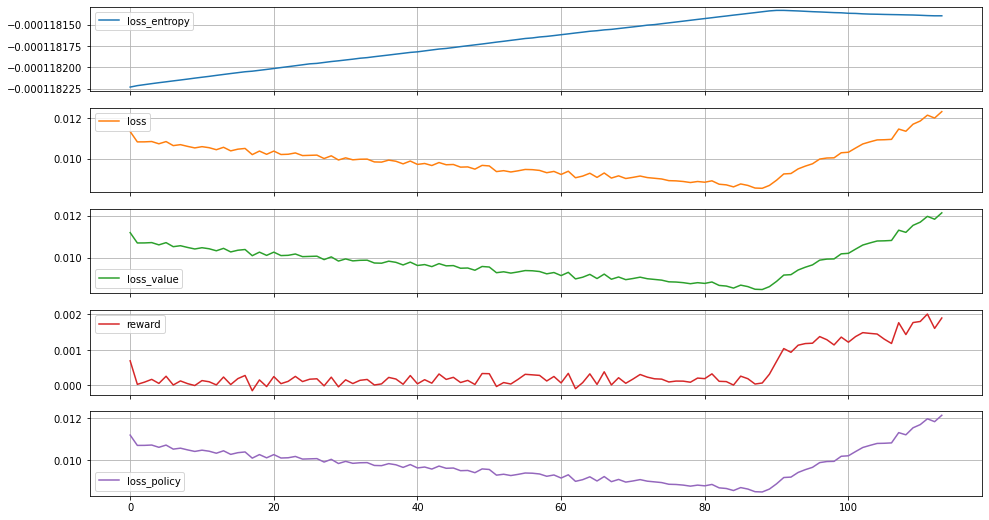

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
pd.DataFrame(player.training_results).plot(subplots=True,grid=True)

In [7]:
player.end_sim()

In [17]:
player.states

[tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0.0000, 0.0558, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0369, 0.0000]]),
 tensor([[0.0114, 0.0793, 0.0000, 0.0000, 0.0000, 0.0000, 0.1569, 0.0582]]),
 tensor([[0.0281, 0.0988, 0.0140, 0.0000, 0.0000, 0.0000, 0.2397, 0.1748]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2096, 0.2907]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1603, 0.4126]])

In [7]:
player.act(True)

TypeError: act() takes 1 positional argument but 2 were given

In [9]:
player.end_sim()

In [9]:
player.pause_sim()

In [7]:
player.start_sim()

In [13]:
##useful methods

rob.get_sim_time()

rob.get_image_front()

rob.read_irs()

rob.move()

rob.pause_simulation()

rob.stop_world()


469754